# Time Zero Analysis and Correction

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

## Loading in Data

__s1__

In [123]:
dI_1 = np.loadtxt("data_files/dI_s1_0-500_12-18-2023.txt")
s_1 = np.loadtxt("data_files/s_s1_0-500_12-18-2023.txt")
t_1 = np.loadtxt("data_files/realtime_s1_0-500_12-18-2023.txt")
stage_1 = np.loadtxt("data_files/stage_s1_0-500_12-18-2023.txt")

dI_2 = np.loadtxt("data_files/dI_s1_500-1000_12-18-2023.txt")
s_2 = np.loadtxt("data_files/s_s1_500-1000_12-18-2023.txt")
t_2 = np.loadtxt("data_files/realtime_s1_500-1000_12-18-2023.txt")
stage_2 = np.loadtxt("data_files/stage_s1_500-1000_12-18-2023.txt")

dI_3 = np.loadtxt("data_files/dI_s1_1000-1500_12-18-2023.txt")
s_3 = np.loadtxt("data_files/s_s1_1000-1500_12-18-2023.txt")
t_3 = np.loadtxt("data_files/realtime_s1_1000-1500_12-18-2023.txt")
stage_3 = np.loadtxt("data_files/stage_s1_1000-1500_12-04-2023.txt")

dI_4 = np.loadtxt("data_files/dI_s1_1500-end_12-18-2023.txt")
s_4 = np.loadtxt("data_files/s_s1_1500-end_12-18-2023.txt")
t_4 = np.loadtxt("data_files/realtime_s1_1500-end_12-18-2023.txt")
stage_4 = np.loadtxt("data_files/stage_s1_1500-end_12-18-2023.txt")

__s4__

In [122]:
dI_1 = np.loadtxt("data_files/dI_s4_0-1000_12-05-2023.txt")
s_1 = np.loadtxt("data_files/s_s4_0-1000_12-05-2023.txt")
t_1 = np.loadtxt("data_files/realtime_s4_0-1000_12-05-2023.txt")
stage_1 = np.loadtxt("data_files/stage_s4_0-1000_12-05-2023.txt")

dI_2 = np.loadtxt("data_files/dI_s4_1000-2000_12-05-2023.txt")
s_2 = np.loadtxt("data_files/s_s4_1000-2000_12-05-2023.txt")
t_2 = np.loadtxt("data_files/realtime_s4_1000-2000_12-05-2023.txt")
stage_2 = np.loadtxt("data_files/stage_s4_1000-2000_12-05-2023.txt")

dI_3 = np.loadtxt("data_files/dI_s4_2000-3000_12-05-2023.txt")
s_3 = np.loadtxt("data_files/s_s4_2000-3000_12-05-2023.txt")
t_3 = np.loadtxt("data_files/realtime_s4_2000-3000_12-05-2023.txt")
stage_3 = np.loadtxt("data_files/stage_s4_2000-3000_12-05-2023.txt")

dI_4 = np.loadtxt("data_files/dI_s4_3000-4000_12-05-2023.txt")
s_4 = np.loadtxt("data_files/s_s4_3000-4000_12-05-2023.txt")
t_4 = np.loadtxt("data_files/realtime_s4_3000-4000_12-05-2023.txt")
stage_4 = np.loadtxt("data_files/stage_s4_3000-4000_12-05-2023.txt")

In [105]:
print(dI_1.shape)
print(dI_2.shape)
print(dI_3.shape)
print(dI_4.shape)

(37, 463)
(37, 463)
(37, 464)
(37, 463)


In [124]:
# dI_2 = dI_2.T
# dI_2 = dI_2[:451]
# dI_2 = dI_2.T

dI_3 = dI_3.T
dI_3 = dI_3[:463]
dI_3 = dI_3.T

# dI_4 = dI_4.T
# dI_4 = dI_4[:451]
# dI_4 = dI_4.T

## Combining Data -- Index

In [20]:
idx_1 = np.arange(0, 37)
idx_2 = np.arange(-2, 35)
idx_3 = np.arange(1, 38)
idx_4 = np.arange(2, 39) 

In [21]:
stage_temp = np.concatenate((stage_1, stage_2, stage_3, stage_4), axis=0) 
t_temp = np.concatenate((t_1, t_2, t_3, t_4), axis=0)
s_temp = np.concatenate((s_1, s_2, s_3, s_4), axis=0)
dI_temp = np.concatenate((dI_1, dI_2, dI_3, dI_4), axis=0)
idx_temp = np.concatenate((idx_1, idx_2, idx_3, idx_4), axis=0)
print(idx_temp)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 -2 -1  0  1  2  3  4  5  6  7  8
  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37  2  3  4  5  6  7  8  9 10
 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38]


In [144]:
uni_idx = np.unique(idx_temp) 
print(len(uni_idx))
uni_time = np.unique(t_temp)

41


TypeError: Dimensions of C (41, 464) should be one smaller than X(464) and Y(37) while using shading='flat' see help(pcolor)

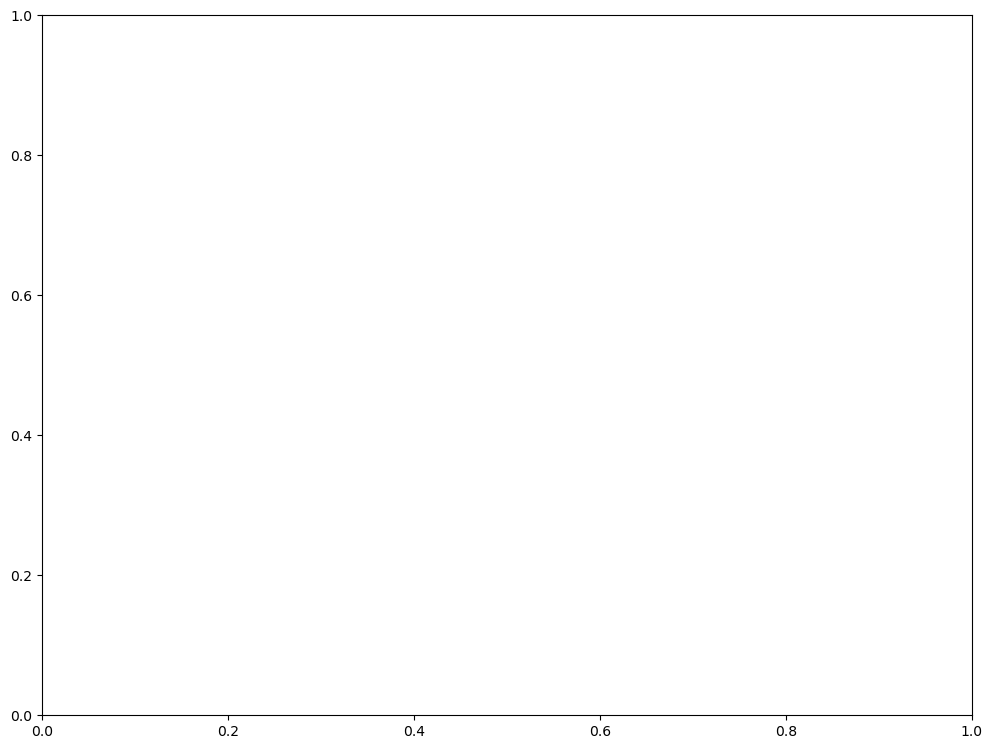

In [146]:
angs = '\u00C5';
s_cali = 0.0225

RoI_1 = [2.7, 3.6];
RoI_2 = [3.9, 4.7];

plt.figure(figsize=(12,20))
plt.subplot(2,1,1)
plt.pcolor(s_1,uni_time,ave_data,cmap='bwr');
plt.clim(vmin=-0.03, vmax=0.03);
plt.colorbar()
plt.axvline(x = RoI_1[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_1[1], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_2[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_2[1], color = 'k', linestyle = '-',linewidth=1);
plt.ylim(-0.5, 2)
plt.xlim(2,7)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,1,2)

print(round(RoI_1[0]/0.0215))
Inte_1 = ave_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = ave_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1)
Inte_2 = ave_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
std_2 = ave_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1);
plt.subplot(2,1,2)
plt.errorbar(uni_time,Inte_1, yerr=std_1,  fmt='-o',  label=str(RoI_1)+' '+angs);
plt.errorbar(uni_time,Inte_2, yerr=std_2,  fmt='-o', label=str(RoI_2)+' '+angs);
plt.xlim(-1, 2)
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('ΔI/I of Select Features')

plt.show()

## Combining Data -- Stage

In [137]:
stage_1[2:25] = stage_4[2:25]

stage_2[2:25] = stage_2[2:25] - 0.02

stage_3[2:25] = stage_3[2:25] - 0.02

stage_4[2:25] = stage_1[2:25] - 0.03

In [126]:
print(stage_1)
print(stage_2)
print(stage_3)
print(stage_4)

[108.   108.01 108.6  108.61 108.62 108.63 108.64 108.65 108.66 108.67
 108.68 108.69 108.7  108.71 108.72 108.73 108.74 108.75 108.76 108.77
 108.78 108.79 108.8  108.81 108.82 108.85 108.88 108.91 108.94 108.97
 109.05 109.2  109.35 109.5  110.17 111.67 116.17]
[108.   108.01 108.58 108.59 108.6  108.61 108.62 108.63 108.64 108.65
 108.66 108.67 108.68 108.69 108.7  108.71 108.72 108.73 108.74 108.75
 108.76 108.77 108.78 108.79 108.8  108.85 108.88 108.91 108.94 108.97
 109.05 109.2  109.35 109.5  110.17 111.67 116.17]
[108.   108.01 108.58 108.59 108.6  108.61 108.62 108.63 108.64 108.65
 108.66 108.67 108.68 108.69 108.7  108.71 108.72 108.73 108.74 108.75
 108.76 108.77 108.78 108.79 108.8  108.85 108.88 108.91 108.94 108.97
 109.05 109.2  109.35 109.5  110.17 111.67 116.17]
[108.   108.01 108.56 108.57 108.58 108.59 108.6  108.61 108.62 108.63
 108.64 108.65 108.66 108.67 108.68 108.69 108.7  108.71 108.72 108.73
 108.74 108.75 108.76 108.77 108.78 108.85 108.88 108.91 108.94 10

In [127]:
stage_temp = np.concatenate((stage_4, stage_3, stage_2, stage_1), axis=0) 
print(stage_temp)
s_temp = np.concatenate((s_4, s_3, s_2, s_1), axis=0)
dI_temp = np.concatenate((dI_4, dI_3, dI_2, dI_1), axis=0)
#print(np.where(stage_temp==108.)[0])

[108.   108.01 108.56 108.57 108.58 108.59 108.6  108.61 108.62 108.63
 108.64 108.65 108.66 108.67 108.68 108.69 108.7  108.71 108.72 108.73
 108.74 108.75 108.76 108.77 108.78 108.85 108.88 108.91 108.94 108.97
 109.05 109.2  109.35 109.5  110.17 111.67 116.17 108.   108.01 108.58
 108.59 108.6  108.61 108.62 108.63 108.64 108.65 108.66 108.67 108.68
 108.69 108.7  108.71 108.72 108.73 108.74 108.75 108.76 108.77 108.78
 108.79 108.8  108.85 108.88 108.91 108.94 108.97 109.05 109.2  109.35
 109.5  110.17 111.67 116.17 108.   108.01 108.58 108.59 108.6  108.61
 108.62 108.63 108.64 108.65 108.66 108.67 108.68 108.69 108.7  108.71
 108.72 108.73 108.74 108.75 108.76 108.77 108.78 108.79 108.8  108.85
 108.88 108.91 108.94 108.97 109.05 109.2  109.35 109.5  110.17 111.67
 116.17 108.   108.01 108.6  108.61 108.62 108.63 108.64 108.65 108.66
 108.67 108.68 108.69 108.7  108.71 108.72 108.73 108.74 108.75 108.76
 108.77 108.78 108.79 108.8  108.81 108.82 108.85 108.88 108.91 108.94
 108.9

In [129]:
uni_stage = np.round(np.unique(stage_temp), decimals=2)
stage_temp = stage_temp.round(decimals=2)
print(uni_stage.shape)

(41,)


In [130]:
print("stage positions", stage_1)
print("combined stage positions", uni_stage)

stage positions [108.   108.01 108.6  108.61 108.62 108.63 108.64 108.65 108.66 108.67
 108.68 108.69 108.7  108.71 108.72 108.73 108.74 108.75 108.76 108.77
 108.78 108.79 108.8  108.81 108.82 108.85 108.88 108.91 108.94 108.97
 109.05 109.2  109.35 109.5  110.17 111.67 116.17]
combined stage positions [108.   108.01 108.56 108.57 108.58 108.59 108.6  108.61 108.62 108.63
 108.64 108.65 108.66 108.67 108.68 108.69 108.7  108.71 108.72 108.73
 108.74 108.75 108.76 108.77 108.78 108.79 108.8  108.81 108.82 108.85
 108.88 108.91 108.94 108.97 109.05 109.2  109.35 109.5  110.17 111.67
 116.17]


In [131]:
%%time
stage_len = len(uni_stage);               #  Number of delays
ave_data = []

for i in range(stage_len):
    #print(uni_stage[i])
    temp_data = dI_temp[np.where(stage_temp==uni_stage[i])[0]];
    #print(temp_data.shape)
    temp_ave= np.nanmean(temp_data,axis=0);
    ave_data.append(temp_ave)


CPU times: user 2.29 ms, sys: 0 ns, total: 2.29 ms
Wall time: 2 ms


<timed exec>:8: RuntimeWarning: Mean of empty slice


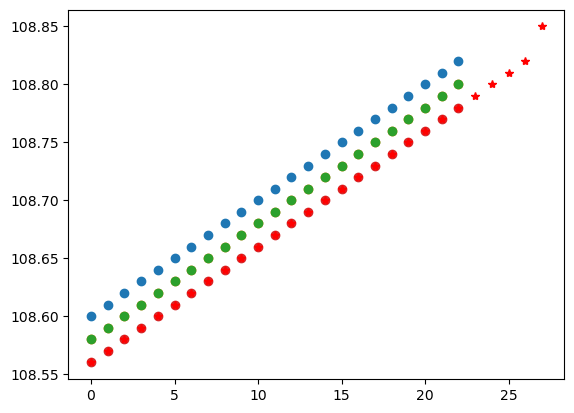

In [132]:
plt.figure()
plt.plot(stage_1[2:25], "o")
plt.plot(stage_2[2:25], "o")
plt.plot(stage_3[2:25], "o")
plt.plot(stage_4[2:25], "o")
plt.plot(uni_stage[2:30], "*r")
plt.show()

In [133]:
ave_data = np.array(ave_data)
ave_data.shape

(41, 463)

In [134]:
posi_0 = 108.63
uni_time = (uni_stage - posi_0)/0.15
print(len(uni_time))

41


## Combining Data -- old

Need to figure out a smarter way to do this

In [83]:
t_temp = np.concatenate((t_1, t_2, t_3, t_4), axis=0) 
s_temp = np.concatenate((s_1, s_2, s_3, s_4), axis=0)
dI_temp = np.concatenate((dI_1, dI_2, dI_3, dI_4), axis=0)

In [84]:
t_temp

array([-4.2       , -4.13333333, -0.2       , -0.13333333, -0.06666667,
        0.        ,  0.06666667,  0.13333333,  0.2       ,  0.26666667,
        0.33333333,  0.4       ,  0.46666667,  0.53333333,  0.6       ,
        0.66666667,  0.73333333,  0.8       ,  0.86666667,  0.93333333,
        1.        ,  1.06666667,  1.13333333,  1.2       ,  1.26666667,
        1.46666667,  1.66666667,  1.86666667,  2.06666667,  2.26666667,
        2.8       ,  3.8       ,  4.8       ,  5.8       , 10.26666667,
       20.26666667, 50.26666667, -4.2       , -4.13333333, -0.2       ,
       -0.13333333, -0.06666667,  0.        ,  0.06666667,  0.13333333,
        0.2       ,  0.26666667,  0.33333333,  0.4       ,  0.46666667,
        0.53333333,  0.6       ,  0.66666667,  0.73333333,  0.8       ,
        0.86666667,  0.93333333,  1.        ,  1.06666667,  1.13333333,
        1.2       ,  1.26666667,  1.46666667,  1.66666667,  1.86666667,
        2.06666667,  2.26666667,  2.8       ,  3.8       ,  4.8 

In [85]:
uni_time = np.unique(t_temp.round(decimals=3))
uni_time

array([-4.2  , -4.133, -0.2  , -0.133, -0.067,  0.   ,  0.067,  0.133,
        0.2  ,  0.267,  0.333,  0.4  ,  0.467,  0.533,  0.6  ,  0.667,
        0.733,  0.8  ,  0.867,  0.933,  1.   ,  1.067,  1.133,  1.2  ,
        1.267,  1.467,  1.667,  1.867,  2.067,  2.267,  2.8  ,  3.8  ,
        4.8  ,  5.8  , 10.267, 20.267, 50.267])

In [33]:
%%time
time_len = len(uni_time);               #  Number of delays
ave_data = []

for i in range(time_len):
    temp_data = dI_temp[np.where(t_temp==uni_time[i])[0]];
    temp_ave= np.nanmean(temp_data,axis=0);
    ave_data.append(temp_ave)

CPU times: user 4 ms, sys: 1.44 ms, total: 5.44 ms
Wall time: 5.27 ms


<timed exec>:6: RuntimeWarning: Mean of empty slice


In [34]:
ave_data = np.array(ave_data)

In [35]:
ave_data.shape

(93, 463)

## Plot Results

129
135


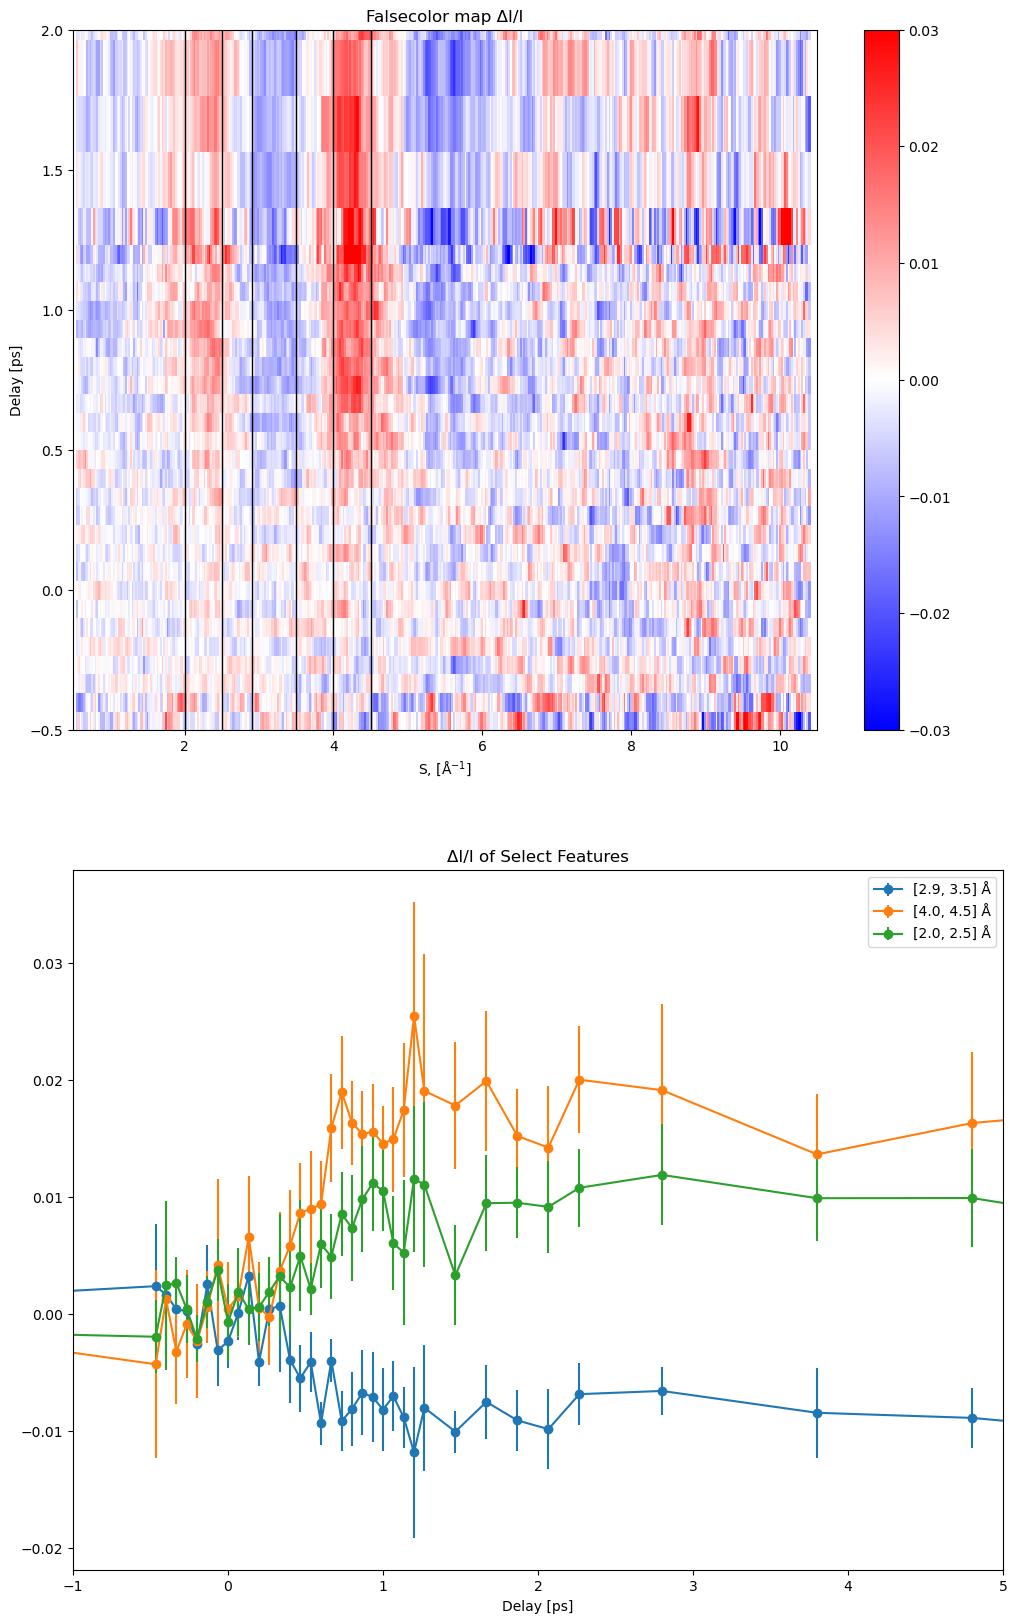

In [135]:
angs = '\u00C5';
s_cali = 0.0225
RoI_1 = [2.9, 3.5];
RoI_2 = [4.0, 4.5];
RoI_3 = [2.0, 2.5];
print(round(RoI_1[0]/0.0225))
Inte_1 = ave_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = ave_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1)
Inte_2 = ave_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
std_2 = ave_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1);
Inte_3 = ave_data[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].mean(axis=1);
std_3 = ave_data[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].std(axis=1);

plt.figure(figsize=(12,20))
plt.subplot(2,1,1)
plt.pcolor(s_1,uni_time,ave_data,cmap='bwr');
plt.clim(vmin=-0.03, vmax=0.03);
plt.colorbar()
plt.axvline(x = RoI_1[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_1[1], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_2[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_2[1], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_3[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_3[1], color = 'k', linestyle = '-',linewidth=1);
plt.ylim(-0.5, 2)
plt.xlim(0.5,10.5)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,1,2)

print(round(RoI_1[0]/0.0215))
Inte_1 = ave_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = ave_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1)
Inte_2 = ave_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
std_2 = ave_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1);
Inte_3 = ave_data[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].mean(axis=1);
std_3 = ave_data[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].std(axis=1);
plt.subplot(2,1,2)
plt.errorbar(uni_time,Inte_1, yerr=std_1,  fmt='-o',  label=str(RoI_1)+' '+angs);
plt.errorbar(uni_time,Inte_2, yerr=std_2,  fmt='-o', label=str(RoI_2)+' '+angs);
plt.errorbar(uni_time, Inte_3, yerr = std_3, fmt='-o', label=str(RoI_3)+' '+angs)
plt.xlim(-1, 5)
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('ΔI/I of Select Features')

plt.show()

## T0 Fitting

Fit parameters: 
t_0 = 0.5071  ps +-  0.0343  ps
FWHM =  0.4259 ps 0.1079 ps




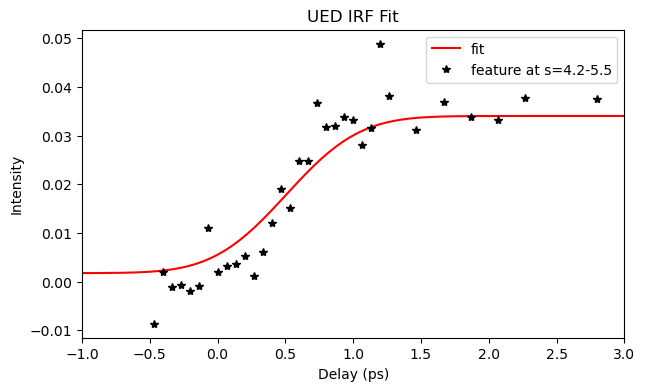

In [136]:
t0_1= Inte_2-Inte_1+Inte_3


A = 0.04
t0 = 0.0
sigma = 0.5
offset = 0
x0 = [A, t0, sigma,offset]
# ## when fitting with an error function
import scipy
def equations(t, A, t0, sigma, offset): #def equations
    fit = A*(scipy.special.erf((t-t0)/(np.sqrt(2)*sigma)))+offset
    return fit

def erf_fit(t, A, t0, sigma, offset):
    fit = A* scipy.special.erf(((t-t0)/(sigma/(np.sqrt(2*np.log(2)))))*np.sqrt(2))+offset
    return fit 

# yo = equations(t, A, t0, sigma, offset) #equations
popt, pcov, id, _, _ = curve_fit(erf_fit, uni_time[4:25], t0_1[4:25], p0 = x0, maxfev = 5000000, method='lm',full_output=True)
t_new = np.linspace(uni_time[0],uni_time[-1],1000)
## error func fit
A, t0, sigma, offset = popt
print("Fit parameters: ")
print("=====================================================")

print("t_0 =", '%1.4f '%(popt[1]),'ps +- ','%1.4f '%np.sqrt(pcov[1,1]),"ps")
print("FWHM = ", '%1.4f'%(popt[2]), 'ps', '%1.4f' %np.sqrt(pcov[2,2]), "ps")

print("\n")
y_new = equations(t_new, *popt)
plt.figure(figsize=(7,4))
# plt.plot(t,yo,color=‘purple’,ls=‘--’)
plt.plot(t_new,y_new,color='red', label="fit")
plt.plot(uni_time, t0_1,'*',color='black', label="feature at s=4.2-5.5")
plt.xlim(-1,3)
plt.xlabel("Delay (ps)")
plt.ylabel("Intensity")
plt.title("UED IRF Fit")
plt.legend()
plt.show()

## Gaussian Filtering

In [441]:
def gaussian_filter_2d(data_array, sig=1):
    """Applies the scipy.ndimage.gaussian_filter() on the 2D data array. Returns filtered images"""
    gf_filtered = gaussian_filter(data_array, sig)
    return gf_filtered

In [442]:
gf_data = gaussian_filter_2d(ave_data)

98


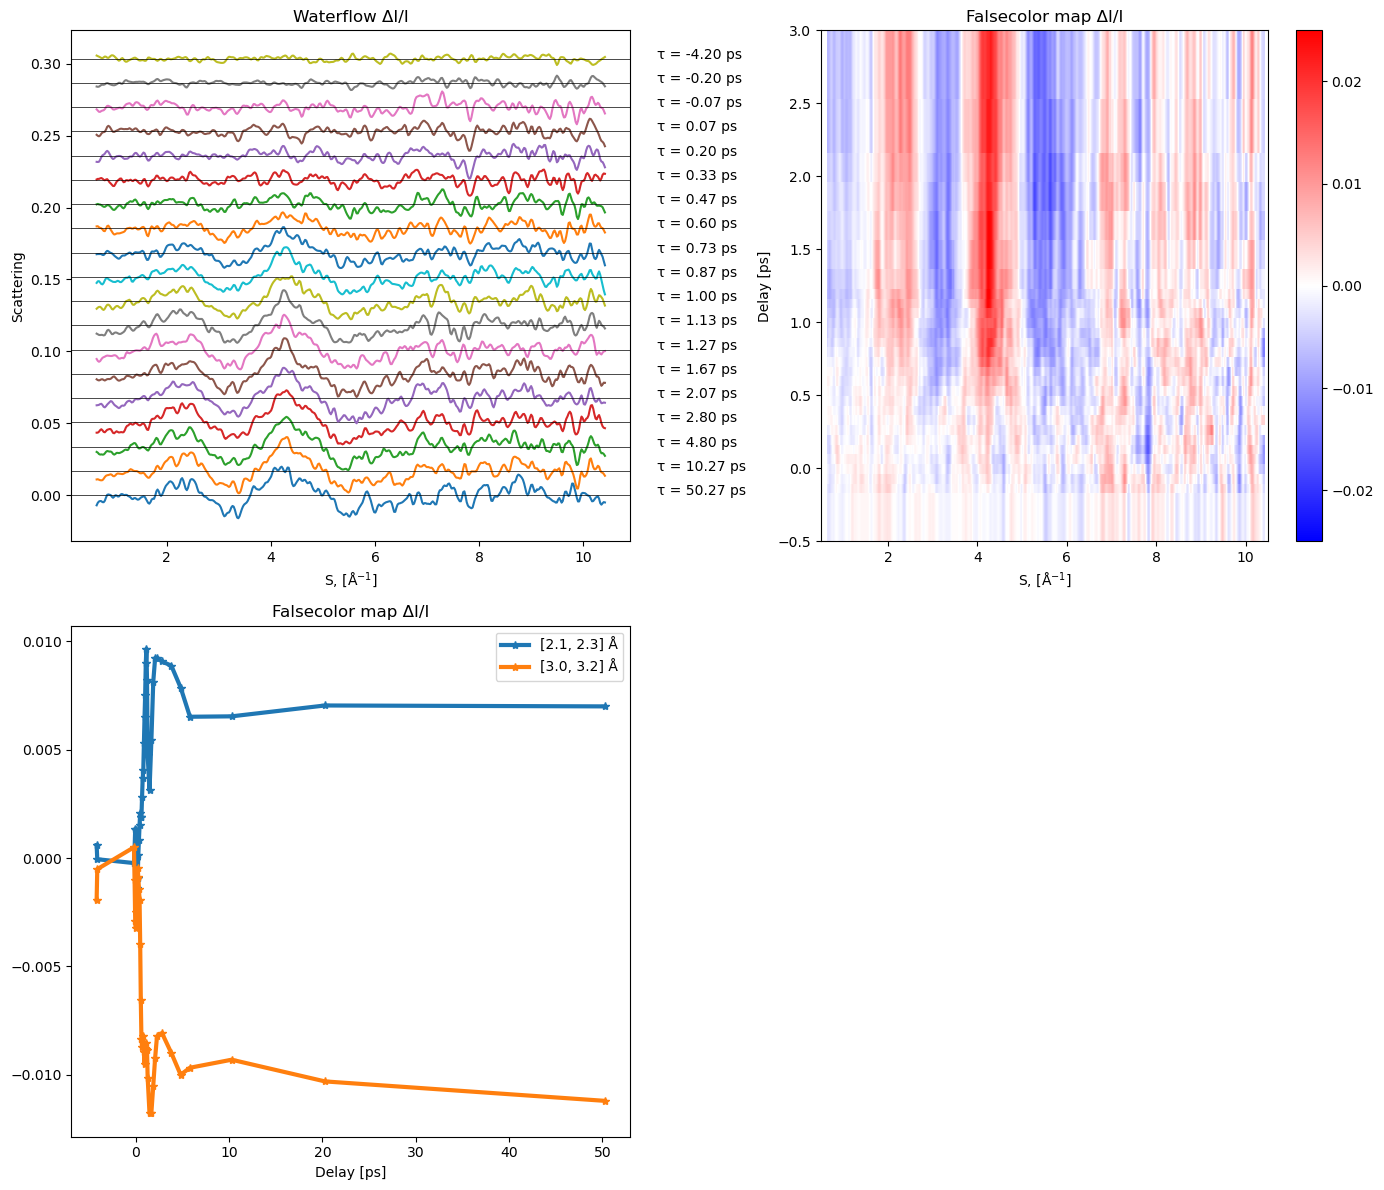

In [454]:
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
for i in range(stage_len):
    if i%2 == 0:
        plt.plot(s_1,gf_data[stage_len-i-1] + np.nanmax(gf_data)*(i)/3);
        plt.text(s_1[-1]+1,np.nanmax(gf_data)*(i)/3, r'τ = {0:.2f} ps'.format(uni_time[stage_len-i-1]))
        plt.axhline(y = np.nanmax(gf_data)*(i)/3, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Scattering');
plt.title('Waterflow ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s_1,uni_time,gf_data,cmap='bwr');
plt.clim(vmin=-0.025, vmax=0.025);
plt.colorbar()
plt.xlim(0.5, 10.5)
plt.ylim(-0.5, 3)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,3)
RoI_1 = [2.1, 2.3];
RoI_2 = [3.0, 3.2];
print(round(RoI_1[0]/0.0215))
Inte_1 = gf_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
Inte_2 = gf_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
plt.plot(uni_time,Inte_1,'-*',linewidth=3,label=str(RoI_1)+' '+angs);
plt.plot(uni_time,Inte_2,'-*',linewidth=3,label=str(RoI_2)+' '+angs);
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.tight_layout()
plt.show()

# plt.tight_layout()
# plt.show()